## Distribution network reconfiguration

In [1]:
import copy
import numpy as np
from gurobipy import *
from scipy import sparse
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt
import pickle

class Env_dnr():
    '''
    code for distribution network reconfiguration
    input:
        case                        Required        Standard IEEE test system format
        Re_busi, RE_p, RE_q         Optional        Nodes for renewable energy (RE) access, active power of RE, reactive power of RE     
        load_P, load_Q              Optional        active load of dsitribution network (DN), reactive load of DN, 
    output:
        objective
        Calculation time
    '''
    def __init__(self) -> None:
        self.case = []
        self.is_RE = False
        self.Re_diat = []
    

    def if_equal(self,loop1, loop2):
        # whether two power loops are equal, if equal, delete one of them
        for i in loop1:
            if i not in loop2:  
                return False
        for i in loop2:
            if i not in loop1:
                return False
        return True 
    
    def del_repeat(self,Loop):
        # delete repeat power loops
        loop = list(deepcopy(Loop))
        while 1:
            for i in range(len(loop)):
                for j in range(i+1, len(loop)):
                    if_del = self.if_equal(loop[i], loop[j])
                    if if_del:
                        del loop[i]
                        break
                if if_del:
                    break
            if if_del == False:
                break
        return loop
    
    def Simple_cycle(self, case):
        """
        Calculate all simple cycles of the imput case.
        """
        G = nx.DiGraph()
        bus = np.array([case["bus"][i][0]
                    for i in range(len(case["bus"]))], dtype=int)
        G.add_nodes_from(bus)
        for i in case["branch"]:
            G.add_edge(i[0], i[1])
            G.add_edge(i[1], i[0])
        # nx.draw_networkx(G)       # Plotting simple loops
        # plt.show()

        # loop = sorted( nx.simple_cycles(G) )
        # loop = [tuple(i) for i in nx.simple_cycles(G)]
        loop = [tuple(i) for i in nx.simple_cycles(G)]  

        loop_set = set() 
        for i in loop:
            if len(i) >= 3:
                loop_set.add(i)
        loop_set = self.del_repeat(loop_set)

        return loop_set

    def Loop_branch(self, case):
        """
        Calculate all power loops of the imput case. Its output is in binary.
        """
        loop_node = self.Simple_cycle(case)
        Loop = deepcopy(loop_node)
        Loop = [i if isinstance(i, list) else list(i) for i in Loop]
        for i in Loop:          
            i.append(i[0])

        bin_loop_branch = np.zeros((len(Loop), len(case["branch"])), dtype=int)
        for c, i in enumerate(Loop):
            for n in range(0, len(i)-1):      
                for b, element in enumerate(case["branch"][:, :2]):
                    if i[n] in element and i[n+1] in element:
                        bin_loop_branch[c, b] = 1
                        break
        return bin_loop_branch
    
    def Draw_loop(self, loop_branch):
        """
        Plot a power loop
        """
        Loop = deepcopy(loop_branch)
        G = nx.Graph()
        G.add_nodes_from(self.case["bus"][:, 0].astype(int))
        G.add_edges_from([tuple(self.case["branch"][i, :2].astype(int))
                        for i, element in enumerate(Loop) if element])
        nx.draw_networkx(G)
        plt.show()

    def set_case(self, case, if_loop = True):
        '''
        input:            case        Standard IEEE test system format
        output:           None
        Function:         Extraction of case data
        '''
        self.case = copy.deepcopy(case)
        branch = self.case['branch']
        bus = self.case["bus"]
        gen = self.case["gen"]
        gencost = self.case["gencost"]
        baseMVA = self.case["baseMVA"]

        n_branch = len(branch)
        n_bus = len(bus)
        node_number = len(bus)

        # branch parameters
        lineblock = np.array( [i for i in branch if abs(i[8])<0.01] )
        self.linei = lineblock[:,0].astype(int)         # The starting node of this branch
        self.linej = lineblock[:,1].astype(int)         # The ending node of this branch
        self.liner = lineblock[:,2]                     # The resistance of this branch
        self.linex = lineblock[:,3]                     # The reactance of this branch
        self.lineb = lineblock[:,4]                     # The susceptance of this branch

        # bus parameters
        branchblock = np.array( [i for i in bus if i[4]**2+i[5]**2 >= 0.01] )
        self.is_earth_line = False
        if branchblock.size != 0:
            self.is_earth_line = True
            self.branchi=branchblock[:,0].astype(int)   # Grounding bus number
            self.branchb=branchblock[:,5]               # Grounding bus susceptance
            self.branchg=branchblock[:,4]               # Grounding bus electric conductance

        # Transformer parameters
        transblock = np.array( [i for i in branch if abs(i[8])>=0.01] )
        self.is_trans = False
        if transblock.size != 0:
            self.is_trans = True
            self.transi=transblock[:,0].astype(int)     # Bus i of transformer parameter
            self.transj=transblock[:,1].astype(int)     # Bus j of transformer parameter
            self.transr=transblock[:,2]                 # Resistance of transformer
            self.transx=transblock[:,3]                 # Reactance of transformer
            self.transk=transblock[:,8]                 # Turns ratio of transformer

        # Bus parameters
        self.diats = [str(x) for x in np.arange(len(bus))+1]                 
        powblock = bus
        powi=powblock[:,0].astype(int)                                       # bus number
        powpdi=powblock[:,2]/baseMVA                                         # acitve power demand of this bus
        powqdj=powblock[:,3]/baseMVA                                         # reactive power demand of this bus
        self.active_load_diat = dict(zip(self.diats,powpdi.tolist()))
        self.reactive_load_diat = dict(zip(self.diats,powqdj.tolist()))

        # Bus voltage constraint
        powV = powblock[:,-2:]
        self.bus_V_max = dict(zip(self.diats, powV[:,0].tolist()))
        self.bus_V_min = dict(zip(self.diats, powV[:,1].tolist()))

        # PV bus parameters
        pvblock=np.array( [i for i in bus if abs(i[1]-2) < 0.01] )          
        self.is_pv_bus = False
        if branchblock.size != 0:
            self.is_pv_bus = True
            self.pv_diat = [str(int(x)) for x in pvblock[:,0].astype(int)]          
            pvi=pvblock[:,0]                                                            # pv bus number
            pvv=pvblock[:,7]                                                            # voltage of this pv bus
            self.pvv_diat = dict(zip(self.pv_diat,(pvv).tolist()))

        # Generator parameters
        Gfactorblock = copy.deepcopy(gen)
        self.generate_diat = [str(int(x)) for x in Gfactorblock[:,0].astype(int)]       # Generator bus number

        Gc = gencost[:,-1]                                                              # Generator cost parameters c
        Gb = gencost[:,-2]                                                              # Generator cost parameters b
        Ga = gencost[:,-3]                                                              # Generator cost parameters a
        self.Ga_diat = dict(zip(self.generate_diat,Ga))
        self.Gb_diat = dict(zip(self.generate_diat,Gb))
        self.Gc_diat = dict(zip(self.generate_diat,Gc))

        Gp_upper = 100*np.ones(len(Gfactorblock))                                     
        Gp_lower = 0*np.ones(len(Gfactorblock))                                        
        Gq_upper = gen[:,3]                                                          
        Gq_lower = gen[:,4]                                                            
        self.Gp_upper = dict(zip(self.generate_diat,Gp_upper))
        self.Gp_lower = dict(zip(self.generate_diat,Gp_lower))
        self.Gq_upper = dict(zip(self.generate_diat,Gq_upper))
        self.Gq_lower = dict(zip(self.generate_diat,Gq_lower))

        # Balanced bus
        balanceblock = np.array( [i for i in bus if abs(i[1]-3) < 0.01] )
        self.balancei = balanceblock[0, 0].astype(int)                                  # Balanced bus number

        # Set of Connected buses
        self.bus_connect = {i:set() for i in range(1,n_bus+1)}
        for bran in branch:
            # Identifying neighboring nodes for each node.
            b_f, b_t = bran[0:2].astype(int)
            self.bus_connect[b_f].add( str(b_t) )
            self.bus_connect[b_t].add( str(b_f) )
        
        # Calculate the simple loops
        if if_loop:
            try:
                if self.case['name'] == 'case33':
                    self.loop_branch = pickle.load(open('DN_loop.pkl', 'rb'))['case33_data']
                elif self.case['name'] == 'case69':
                    self.loop_branch = pickle.load(open('DN_loop.pkl', 'rb'))['case69_data']
                elif self.case['name'] == 'case118':
                    self.loop_branch = pickle.load(open('DN_loop.pkl', 'rb'))['case118_data']
            except (FileNotFoundError, KeyError) as error:                              # file not exist
                if isinstance(error, FileNotFoundError):
                    loop_branch = {}
                elif isinstance(error, KeyError):
                    loop_branch = pickle.load(open('DN_loop.pkl', 'rb'))
                if self.case['name'] == 'case33':
                    loop_branch['case33_data'] = self.Loop_branch(self.case)
                    self.loop_branch = loop_branch['case33_data']
                elif self.case['name'] == 'case69':
                    loop_branch['case69_data'] = self.Loop_branch(self.case)
                    self.loop_branch = loop_branch['case69_data']
                elif self.case['name'] == 'case118':
                    loop_branch['case118_data'] = self.Loop_branch(self.case)
                    self.loop_branch = loop_branch['case118_data']
                pickle.dump(loop_branch, open('DN_loop.pkl', 'wb'))             

    def set_RE(self, Re_busi, Re_p, Re_q):
        '''
        Re_busi, RE_p, RE_q         Optional        Access bus for renewable energy, active power of RE, reactive power of RE     
        '''
        self.is_RE = True
        self.Re_diat = [str(i) for i in Re_busi]              
        self.Re_p = np.array([i/self.case['baseMVA'] for i in Re_p])
        self.Re_q = np.array([i/self.case['baseMVA'] for i in Re_q])
    
    def set_Load(self,loadP,loadQ):
        '''
        Configuring the power demand for all bus in the system
        '''
        for i in range(len(self.diats)):
            self.case['bus'][i,2] = loadP[i]/self.case['baseMVA']
            self.case['bus'][i,3] = loadQ[i]/self.case['baseMVA']
        self.active_load_diat = dict(zip(self.diats, self.case['bus'][:,2].tolist()))
        self.reactive_load_diat = dict(zip(self.diats, self.case['bus'][:,3].tolist()))

    def Y_admittance(self, Switch_dict = None):
        '''
        Computing the admittance matrix of the case
        Switch_dict: Switch status
        '''
        
        if self.case == []:
            print('Please set case first')
            return None
        
        def cooMatrix(data,row,col,shape, operation):
            Y_ad = { (i,j) : 0 for i in range(shape[0]) for j in range(shape[1]) }
            if operation == '+':
                for i, element in enumerate( zip(row,col) ):
                    Y_ad[element] += data[i]
            elif operation == '-':
                for i, element in enumerate( zip(row,col) ):
                    Y_ad[element] += -data[i]
            return Y_ad
        def dictAdd(shape, number, *args):
            Y_ad = { (i,j) : 0 for i in range(shape[0]) for j in range(shape[1]) }
            for i in range(shape[0]):
                for j in range(shape[1]):
                    for n in range(number):
                        Y_ad[i,j] += args[n][i,j]
            return Y_ad
        
        ## Determine branch status
        if Switch_dict == None:
            Switch_dict = {(f,t):1 for f,t in zip(self.linei, self.linej)  }
        
        ## Compute admittance matrix for a normal branch.
        z1=1.*(self.liner+1j*self.linex)**-1                              
        z11=1.*(self.liner+1j*self.linex)**-1+1j*self.lineb
        z1_r = {bran: np.real(z1[bran]) for bran in range( len(z1) ) }
        z1_i = {bran: np.imag(z1[bran]) for bran in range( len(z1) ) }
        z11_r = {bran: np.real(z11[bran]) for bran in range( len(z11) ) }
        z11_i = {bran: np.imag(z11[bran]) for bran in range( len(z11) ) }

        for i,(f,t) in enumerate( zip(self.linei, self.linej) ):
            z1_r[i] = z1_r[i] * Switch_dict[f, t]
            z1_i[i] = z1_i[i] * Switch_dict[f, t]
            z11_r[i] = z11_r[i] * Switch_dict[f, t]
            z11_i[i] = z11_i[i] * Switch_dict[f, t]

        shape=(len(self.diats),len(self.diats))
        y1_1_r = cooMatrix( z1_r, self.linei-1, self.linej-1, shape, operation = "-")
        y1_2_r = cooMatrix( z1_r, self.linej-1, self.linei-1,shape, operation = "-")
        y1_3_r = cooMatrix( z11_r, self.linei-1, self.linei-1,shape, operation = "+")
        y1_4_r = cooMatrix( z11_r, self.linej-1, self.linej-1,shape, operation = "+")
        y_r = dictAdd(shape, 4, y1_1_r, y1_2_r, y1_3_r, y1_4_r)

        y1_1_i = cooMatrix( z1_i, self.linei-1, self.linej-1, shape, operation = "-")
        y1_2_i = cooMatrix( z1_i, self.linej-1, self.linei-1,shape, operation = "-")
        y1_3_i = cooMatrix( z11_i, self.linei-1, self.linei-1,shape, operation = "+")
        y1_4_i = cooMatrix( z11_i, self.linej-1, self.linej-1,shape, operation = "+")
        y_i = dictAdd(shape, 4, y1_1_i, y1_2_i, y1_3_i, y1_4_i)


        ## Calculate admittance matrix for transformer
        if self.is_trans == True:
            z2=1*(self.transr+1j*self.transx)**-1*(self.transk)**-1                     
            z22=(1-self.transk)*(self.transr+1j*self.transx)**-1*(self.transk)**-1*(self.transk)**-1+z2
            z23=(self.transk-1)*(self.transr+1j*self.transx)**-1*(self.transk)**-1+z2
            y2_1 = -sparse.coo_matrix((z2,(self.transi-1,self.transj-1)),shape )
            y2_2 = -sparse.coo_matrix((z2,(self.transj-1,self.transi-1)),shape )
            y2_3 = sparse.coo_matrix((z22,(self.transi-1,self.transi-1)),shape )
            y2_4 = sparse.coo_matrix((z23,(self.transj-1,self.transj-1)),shape )
            y2=y2_1+y2_2+y2_3+y2_4                                   
            y2_r = { (diat_1, diat_2) : np.real(y2[int(diat_1)-1, int(diat_2)-1]) for diat_1 in self.diats for diat_2 in self.diats }
            y2_i = { (diat_1, diat_2) : np.imag(y2[int(diat_1)-1, int(diat_2)-1]) for diat_1 in self.diats for diat_2 in self.diats }
            y_r = dictAdd(shape, 2, y_r, y2_r)
            y_i = dictAdd(shape, 2, y_i, y2_i)
        
        ## Calculate admittance of grounding bus
        if self.is_earth_line == True:
            y3=sparse.coo_matrix( (self.branchg+1j*self.branchb,(self.branchi-1,self.branchi-1)),shape )
            y3_r = { (diat_1, diat_2) : np.real(y3[int(diat_1)-1, int(diat_2)-1]) for diat_1 in self.diats for diat_2 in self.diats }
            y3_i = { (diat_1, diat_2) : np.imag(y3[int(diat_1)-1, int(diat_2)-1]) for diat_1 in self.diats for diat_2 in self.diats }
            y_r = dictAdd(shape, 2, y_r, y3_r)
            y_i = dictAdd(shape, 2, y_i, y3_i)

        gurobi_martix_dict_g = {(diat_1, diat_2) : y_r[int(diat_1)-1, int(diat_2)-1] for diat_1 in self.diats for diat_2 in self.diats} 
        gurobi_martix_dict_b = {(diat_1, diat_2) : y_i[int(diat_1)-1, int(diat_2)-1] for diat_1 in self.diats for diat_2 in self.diats} 

        return gurobi_martix_dict_g, gurobi_martix_dict_b

    def DNR(self):
        '''
        Output: 
            objective function 
            distribution network reconfiguration plan
        '''
        if self.case == []:
            print('Please set case first')
            return None

        ## Set model parameters
        m = Model('OPF')
        m.params.NonConvex = 2
        m.Params.BarHomogeneous = 1
        m.Params.Seed = 123
        # m.setParam('OutputFlag', 0)               # Print results: 0 = No, 1 = Yes
        self.logRun = {}                            # logging
    
        ## Set independent variables
        active_power_diat = {}
        reactive_power_diat = {}
        C = {}
        S = {}
        P = {}             
        Q = {}       
        if self.is_RE == True:
            Re_p_inject = {}
            Re_q_inject = {}

        for i in self.generate_diat:
            active_power_diat[i] = m.addVar(lb = self.Gp_lower[i], ub = self.Gp_upper[i], name = 'active_power_diat_{}'.format(i))
            reactive_power_diat[i] = m.addVar(lb = self.Gq_lower[i], ub = self.Gq_upper[i], name = 'reactive_power_diat_{}'.format(i))
        for i in self.diats:
            for j in self.diats:
                C[i, j] = m.addVar(lb = -99.9 ,name = 'C_{}_{}'.format(i,j))
                S[i, j] = m.addVar (lb = -99.9  ,name='S_{}_{}'.format(i,j))
                P[i, j] = m.addVar (lb = -99.9  ,name='P_{}_{}'.format(i,j))
                Q[i, j] = m.addVar (lb = -99.9  ,name='Q_{}_{}'.format(i,j))
        if self.is_RE == True:
            for i, j, k in zip( self.Re_diat, self.Re_p, self.Re_q ):
                Re_p_inject[i] =  m.addVar(lb = 0, ub = j, name = 'Re_p{}'.format(i))
                Re_q_inject[i] =  m.addVar(lb = 0, ub = k, name = 'Re_q{}'.format(i))
        
        var_Switch = {}
        for i,j in zip(self.linei, self.linej):
            var_Switch[i, j] = m.addVar(vtype = GRB.BINARY, name="S_brach_{}_{}".format(i,j))     
        gurobi_martix_dict_g, gurobi_martix_dict_b = self.Y_admittance(Switch_dict = var_Switch)
        
        m.addConstr(( quicksum(var_Switch [i,j] for i,j in zip(self.linei, self.linej)) == len(self.diats)-1  ), name='Switch_number')
        for n,l in enumerate(self.loop_branch,1):
            m.addConstr(( quicksum( var_Switch[i,j]*l[t] for t,(i,j) in enumerate( zip(self.linei, self.linej) ) if l[t] >0.05 ) \
                <= quicksum( l[i] for i in range(len(self.linei)))-0.9 ), name = 'Switch_number_{}'.format(n) )
        m.update()


        ## Set constraint conditions
        if self.is_pv_bus == True:
            for i in self.pv_diat: 
                m.addConstr(C[i, i] == self.pvv_diat[i]**2, name='PVv_{}'.format(i))

        def constrainp(i):
            a = gurobi_martix_dict_g[i, i] * C[i, i]
            for j in self.bus_connect[int(i)]:
                a += ( gurobi_martix_dict_g[i,j]*C[i,j]-gurobi_martix_dict_b[i,j]*S[i,j] )
            return (a)

        def constrainq(i):
            a = -gurobi_martix_dict_b[i, i] * C[i, i]
            for j in self.bus_connect[int(i)]:
                a += ( -gurobi_martix_dict_b[i,j]*C[i,j]-gurobi_martix_dict_g[i,j]*S[i,j] )
            return (a)  

        for i in self.diats:
            if i in self.generate_diat and i in self.Re_diat:           # This bus connects the generator and RE
                m.addQConstr( (constrainp(i) ==active_power_diat[i] + Re_p_inject[i] - self.active_load_diat[i]), name="balanceP_{}".format(i) )
                m.addQConstr( (constrainq(i) ==reactive_power_diat[i] + Re_q_inject[i] - self.reactive_load_diat[i]), name="balanceQ_{}".format(i) )
            elif i in self.generate_diat:                               # This bus connects the generator
                m.addQConstr( (constrainp(i) ==active_power_diat[i] - self.active_load_diat[i]), name="balanceP_{}".format(i) )
                m.addQConstr( (constrainq(i) ==reactive_power_diat[i] - self.reactive_load_diat[i]), name="balanceQ_{}".format(i) )
            elif i in self.Re_diat:                                     # This bus connects the RE
                m.addQConstr( (constrainp(i) ==Re_p_inject[i] - self.active_load_diat[i]), name="balanceP_{}".format(i) )
                m.addQConstr( (constrainq(i) ==Re_q_inject[i] - self.reactive_load_diat[i]), name="balanceQ_{}".format(i) )       
            else:                                                       # This bus is not connects the generator and RE
                m.addQConstr( (constrainp(i) == - self.active_load_diat[i]), name="balanceP_{}".format(i) )
                m.addQConstr( (constrainq(i) == - self.reactive_load_diat[i]), name="balanceQ_{}".format(i) ) 

        m.addConstr(C[str(int(self.balancei)),str(int(self.balancei))]==1,name='balancebus')  
        m.addConstrs((C[diat_i, diat_i]<=self.bus_V_max[diat_i]**2 for diat_i in self.diats),name='ClimUP')
        m.addConstrs((C[diat_i, diat_i]>=self.bus_V_min[diat_i]**2 for diat_i in self.diats),name='ClimLow')
        m.addConstrs((C[diat_i, diat_j]==C[diat_j, diat_i] for diat_j in self.diats  for diat_i in self.diats  ),name='C_Constrs')
        m.addConstrs((S[diat_i, diat_j]==-S[diat_j, diat_i] for diat_j in self.diats  for diat_i in self.diats),name='S_Constrs')

        for diat_i in self.diats:
            for diat_j in self.diats:
                m.addQConstr((C[diat_i, diat_j]*C[diat_i, diat_j]+S[diat_i, diat_j]*S[diat_i, diat_j])<=C[diat_i, diat_i]*C[diat_j, diat_j])

        ##  the congestion of the system
        for diat_i in self.diats:
            for diat_j in self.diats:
                m.addQConstr( P[diat_i,diat_j] - (-gurobi_martix_dict_g[diat_i, diat_j]*C[diat_i,diat_i] + gurobi_martix_dict_g[diat_i, diat_j]*C[diat_i,diat_j] - gurobi_martix_dict_b[diat_i, diat_j]*S[diat_i,diat_j]) >=-1e-6)
                m.addQConstr( P[diat_i,diat_j] - (-gurobi_martix_dict_g[diat_i, diat_j]*C[diat_i,diat_i] + gurobi_martix_dict_g[diat_i, diat_j]*C[diat_i,diat_j] - gurobi_martix_dict_b[diat_i, diat_j]*S[diat_i,diat_j]) <=1e-6)
                m.addQConstr( Q[diat_i,diat_j]- (gurobi_martix_dict_b[diat_i, diat_j]*C[diat_i,diat_i] - gurobi_martix_dict_b[diat_i, diat_j]*C[diat_i,diat_j] - gurobi_martix_dict_g[diat_i, diat_j]*S[diat_i,diat_j]) >=-1e-6)
                m.addQConstr( Q[diat_i,diat_j]- (gurobi_martix_dict_b[diat_i, diat_j]*C[diat_i,diat_i] - gurobi_martix_dict_b[diat_i, diat_j]*C[diat_i,diat_j] - gurobi_martix_dict_g[diat_i, diat_j]*S[diat_i,diat_j]) <=-1e-6)
                m.addConstr( P[diat_i,diat_j] >= -10 )
                m.addConstr( P[diat_i,diat_j] <= 10 )
                m.addQConstr( P[diat_i,diat_j]**2.0  + Q[diat_i,diat_j]**2.0 >= -100 )
                m.addQConstr( P[diat_i,diat_j]**2.0  + Q[diat_i,diat_j]**2.0 <= 100 )

        obj = quicksum( active_power_diat[i] for i in self.generate_diat ) - quicksum(self.active_load_diat[i] for i in self.diats )
        if self.is_RE == True:
            obj = obj + quicksum( Re_p_inject[i] for i in self.Re_diat ) + 10* ( quicksum( i for i in self.Re_p )- quicksum( Re_p_inject[i] for i in self.Re_diat ) )
        obj = 10 * obj      # ppc["baseMVA"] = 10

        def callback(model, where):
            if where == GRB.Callback.MIP:
            # Message callback
                objBest = model.cbGet(GRB.Callback.MIP_OBJBST)
                runTime = model.cbGet(GRB.Callback.RUNTIME)
                self.logRun[runTime] = objBest
            
        m.update()
        m.setObjective(obj, GRB.MINIMIZE)
        m.setParam('TimeLimit', 60 )
        m.optimize(callback)

        if list(self.logRun.values())[-1]<=0:
            self.logRun.update((key, 1e10) for key in self.logRun.keys())
        if m.status == 2 or m.status == 9 or m.status == 13:         # Status description: https://www.gurobi.com/documentation/9.5/refman/optimization_status_codes.html
            return self.logRun, m.objVal            
        else:                            
            return self.logRun, 1e6


    def __repr__(self) -> str:
        return 'DNR:' + self.case['name']


In [2]:
'''
results processing
'''
import numpy as np
import collections
import pickle
import pandas as pd

state = collections.namedtuple('state', ['wind1_P', 'wind1_Q','wind2_P','wind2_Q','wind3_P','wind3_Q','pv1_P','pv2_P','pv3_P','load_P','load_Q'])
class State():
    def __init__(self,wind1_P,wind1_Q, wind2_P,wind2_Q, wind3_P,wind3_Q, pv1_P,pv2_P,pv3_P, load_P,load_Q) -> None:
        self._state = []
        for day in range( len( wind1_P ) ):
            for t in range( len(wind1_P[0]) ):
                self._state.append( state( 
                    wind1_P[day,t], wind1_Q[day,t], \
                    wind2_P[day,t], wind2_Q[day,t],\
                    wind3_P[day,t], wind3_Q[day,t],\
                    pv1_P[day,t], pv2_P[day,t], pv3_P[day,t],\
                    load_P[day,t,:], load_Q[day,t,:] \
                    ) )
    def __len__(self): 
        return len(self._state)

    def __getitem__(self, position): 
        return self._state[position]
    
    def my_del(self,position):
        del self._state[position]


class table_data():
    def __init__(self, time1, time2, time3) -> None:
        self.case33_1 = []
        self.case33_2 = []
        self.case33_3 = []

        self.case69_1 = []
        self.case69_2 = []
        self.case69_3 = []

        self.case118_1 = []
        self.case118_2 = []
        self.case118_3 = []

        self.time_str = self.Time_str()
        self.target_time1 = time1
        self.target_time2 = time2
        self.target_time3 = time3
    
    def Time_str(self):
        import datetime
        start_time = datetime.time(10, 0, 0)
        time_array = []

        delta = datetime.timedelta(minutes=15)

        for i in range(16):
            time_str = (datetime.datetime.combine(datetime.date.today(), start_time) + i * delta).strftime('%H:%M')
            time_array.append(time_str)
        return time_array
    
    def data_process(self, x, y, case):
        if 'case33' in case:
            closest_index, closest_num = self.find_closest_num(x, self.target_time1)
            self.case33_1.append(y[closest_index])
            closest_index, closest_num = self.find_closest_num(x, self.target_time2)
            self.case33_2.append(y[closest_index])
            closest_index, closest_num = self.find_closest_num(x, self.target_time3)
            self.case33_3.append(y[closest_index])

        elif 'case69' in case:
            closest_index, closest_num = self.find_closest_num(x, self.target_time1)
            self.case69_1.append(y[closest_index])
            closest_index, closest_num = self.find_closest_num(x, self.target_time2)
            self.case69_2.append(y[closest_index])
            closest_index, closest_num = self.find_closest_num(x, self.target_time3)
            self.case69_3.append(y[closest_index])

        elif 'case118' in case:
            closest_index, closest_num = self.find_closest_num(x, self.target_time1)
            self.case118_1.append(y[closest_index])
            closest_index, closest_num = self.find_closest_num(x, self.target_time2)
            self.case118_2.append(y[closest_index])
            closest_index, closest_num = self.find_closest_num(x, self.target_time3)
            self.case118_3.append(y[closest_index])
    
    def plot_table(self):
        table = {'Case': self.Time_str(),
                'case33_{}s'.format(self.target_time1): self.case33_1,
                'case33_{}s'.format(self.target_time2): self.case33_2,
                'case33_{}s'.format(self.target_time3): self.case33_3,
                'case69_{}s'.format(self.target_time1): self.case69_1,
                'case69_{}s'.format(self.target_time2): self.case69_2,
                'case69_{}s'.format(self.target_time3): self.case69_3,
                'case118_{}s'.format(self.target_time1): self.case118_1,
                'case118_{}s'.format(self.target_time2): self.case118_2,
                'case118_{}s'.format(self.target_time3): self.case118_3 }
        df = pd.DataFrame(table)
        print(df)

    
    def find_closest_num(self,x_list, target):
        closest_index = np.abs(np.array(x_list) - target).argmin()
        closest_num = x_list[closest_index]
        return closest_index, closest_num 

def test(case, env):
    result = {}
    if case['name'] == 'case33': 
        Re_busi = [11,21,24,5,17,31]
        data = pickle.load(open('test_data.pkl', 'rb'))['case33_data']
    elif case['name'] == 'case69':
        Re_busi = [28,45,48,24,51,62]
        data = pickle.load(open('test_data.pkl', 'rb'))['case69_data']
    elif case['name'] == 'case118':
        Re_busi = [27,65,77,29,86,113]
        data = pickle.load(open('test_data.pkl', 'rb'))['case118_data']
    else:
        raise Exception('Only support case33, case69 and case118!!')
    
    env.set_case(case)
    for t, data_now in enumerate( data ):
        print('========================================')
        print('{}, t={}:'.format(case['name'],t))

        Re_p = np.array([data_now.wind1_P, data_now.wind2_P, data_now.wind3_P, \
            data_now.pv1_P, data_now.pv2_P, data_now.pv3_P])
        Re_q = np.array([data_now.wind1_Q, data_now.wind2_Q, data_now.wind3_Q, 0, 0, 0])
        load_P = data_now.load_P
        load_Q = data_now.load_Q
        
        env.set_RE(Re_busi, Re_p, Re_q)
        env.set_Load(load_P, load_Q)
        result2, obj = env.DNR()

        result['{}_{:02d}'.format(case['name'],t)] = result2
    return result  

case33, t=0:
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-17
Set parameter NonConvex to value 2
Set parameter BarHomogeneous to value 1
Set parameter Seed to value 123
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i5-13600KF, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 8378 rows, 4407 columns and 10949 nonzeros
Model fingerprint: 0x99a29194
Model has 3761 quadratic constraints
Variable types: 4370 continuous, 37 integer (37 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  QMatrix range    [1e+00, 1e+02]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+01, 9e+01]
  Bounds range     [8e-05, 1e+02]
  RHS range        [1e-06, 3e+01]
  QRHS range       [1e-06, 1e+02]
Presolve removed 7752 rows and 4108 columns
Presolve time: 0.01s
Presolved: 1132 ro

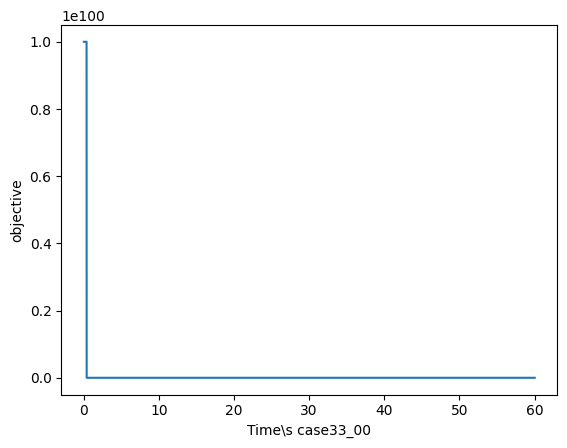

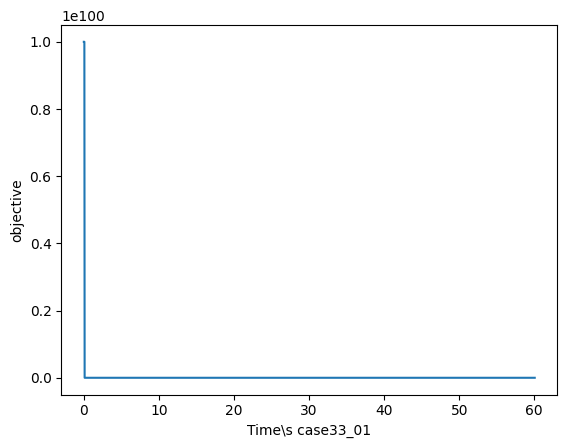

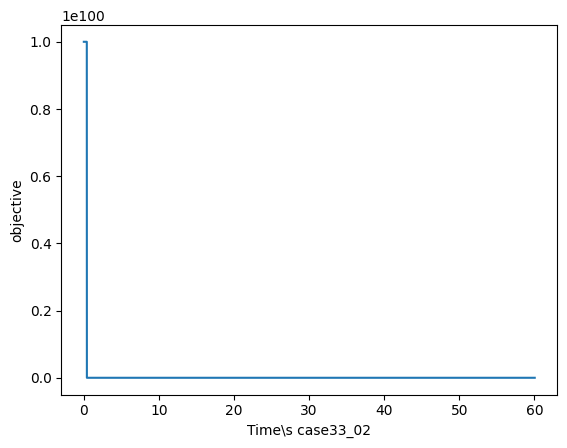

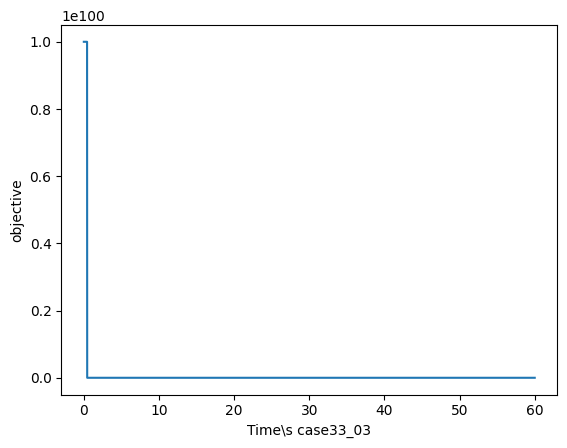

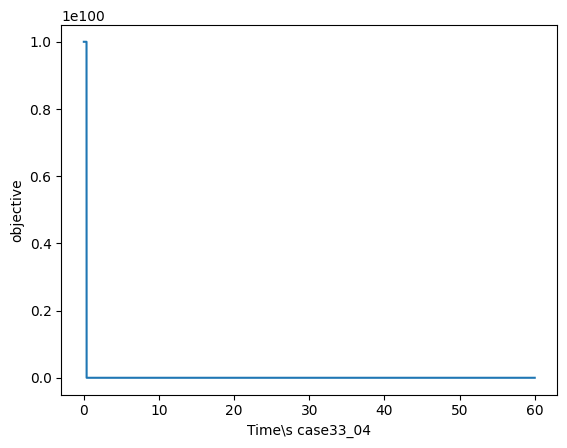

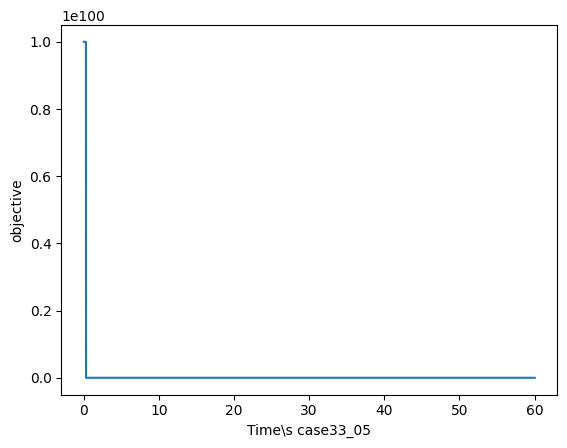

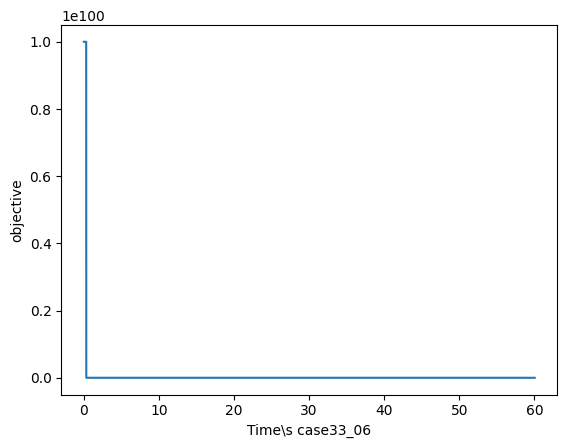

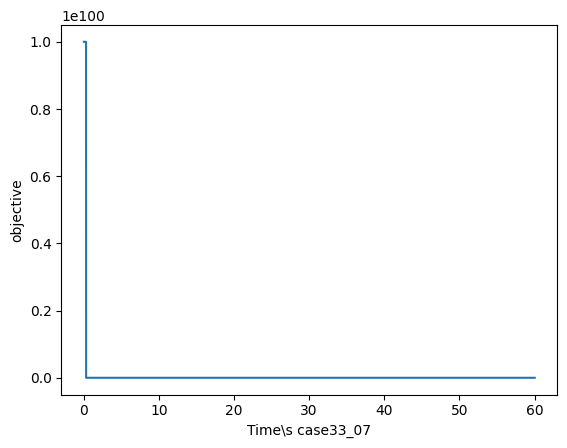

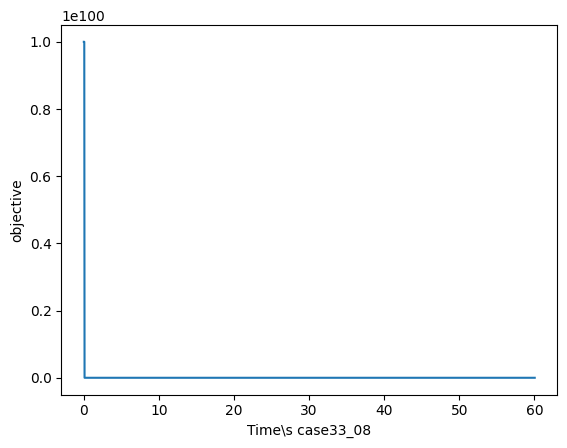

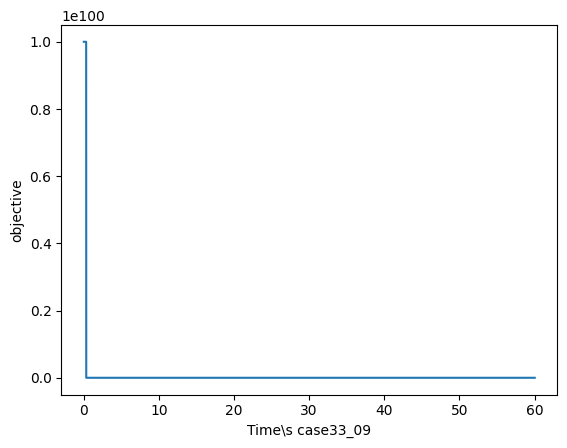

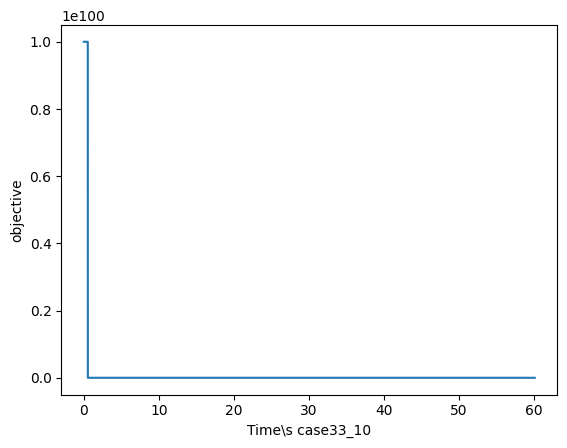

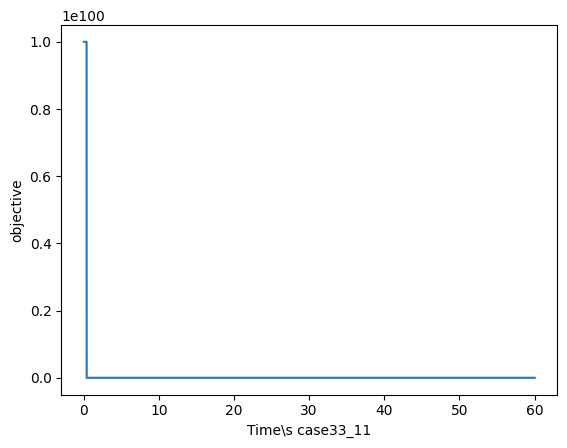

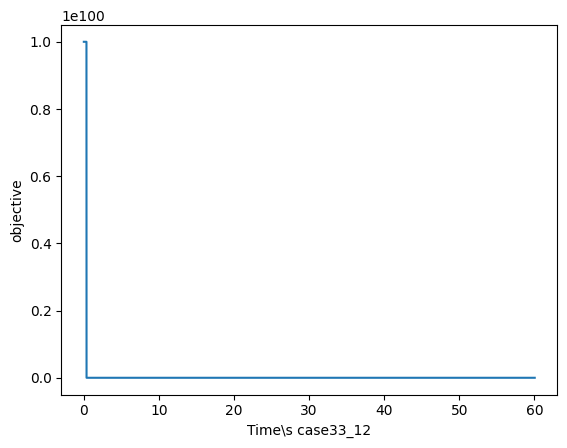

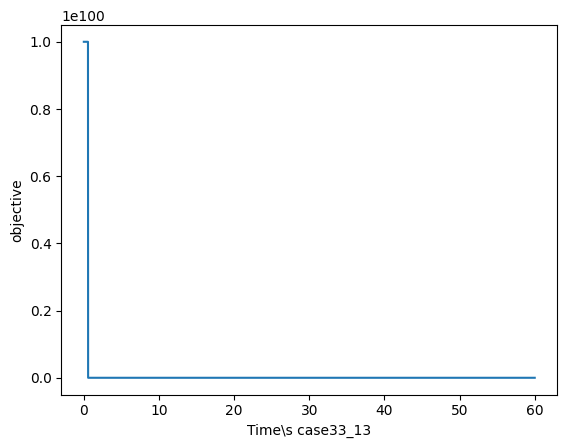

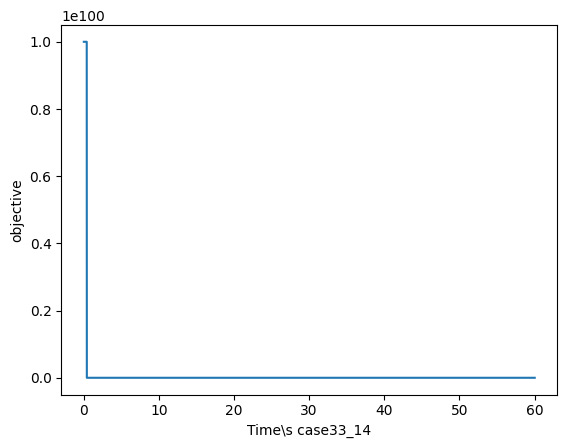

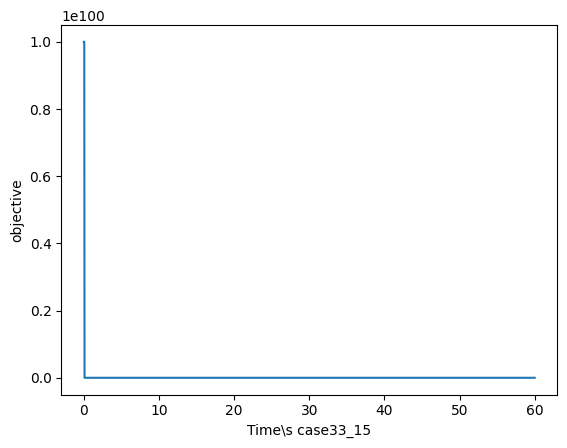

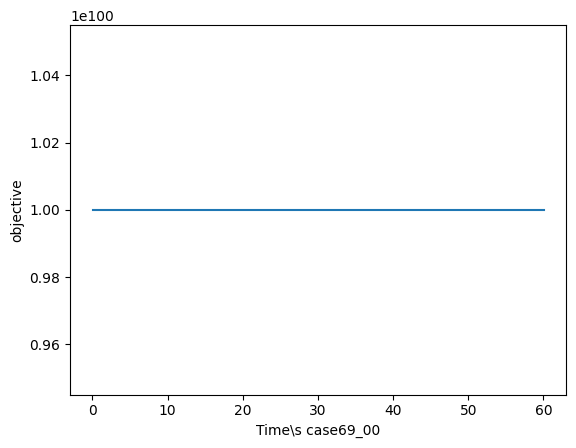

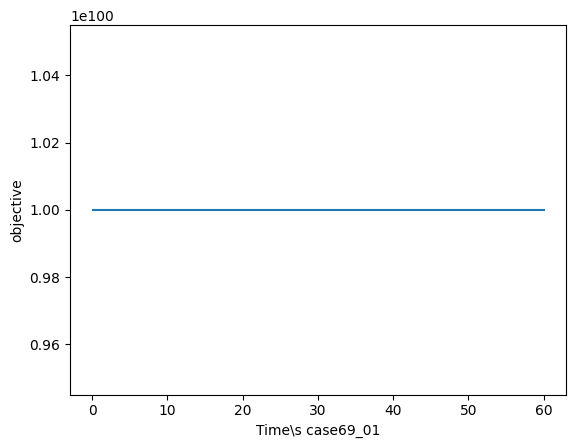

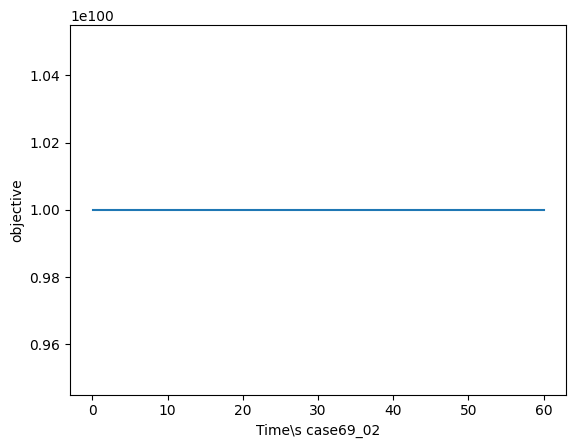

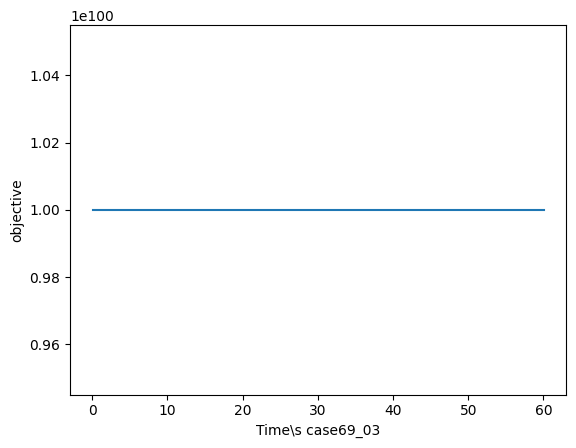

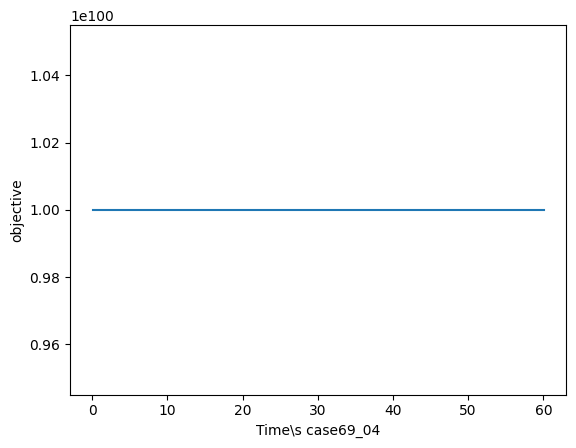

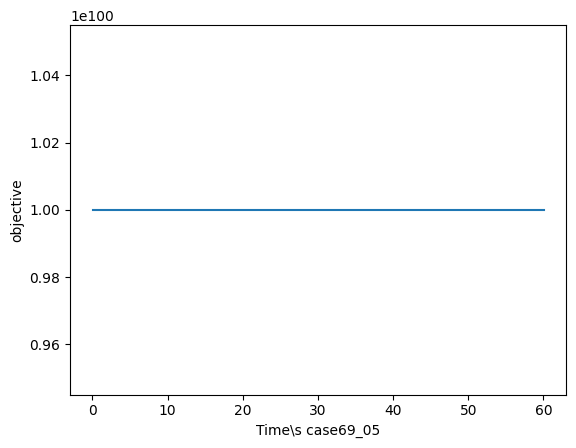

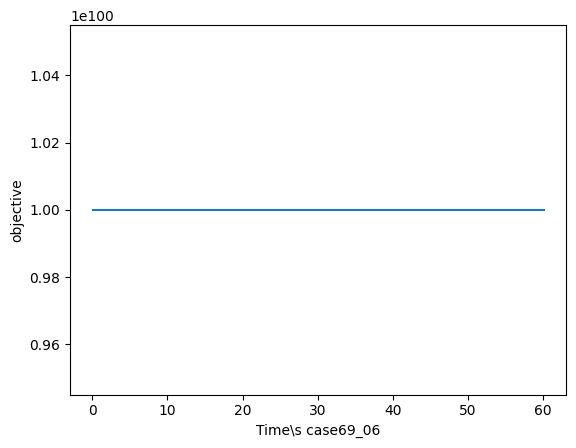

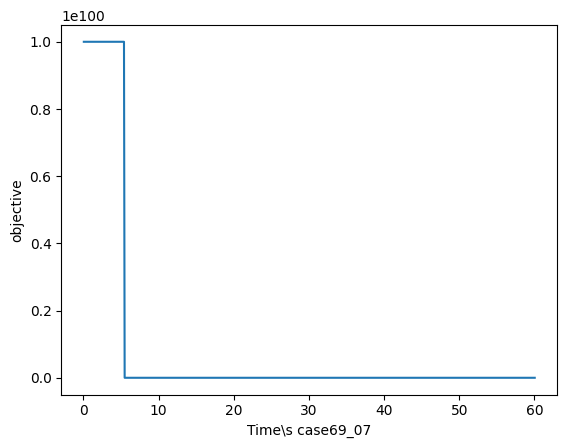

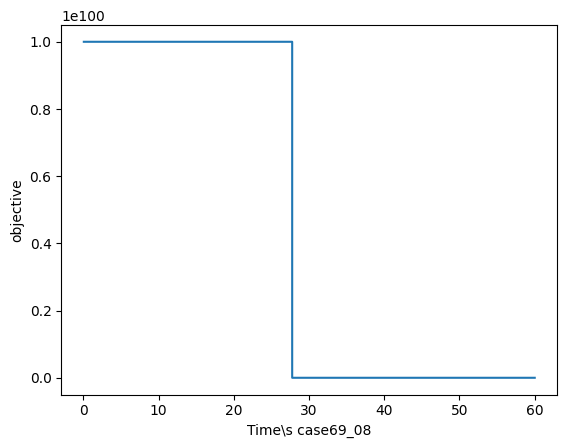

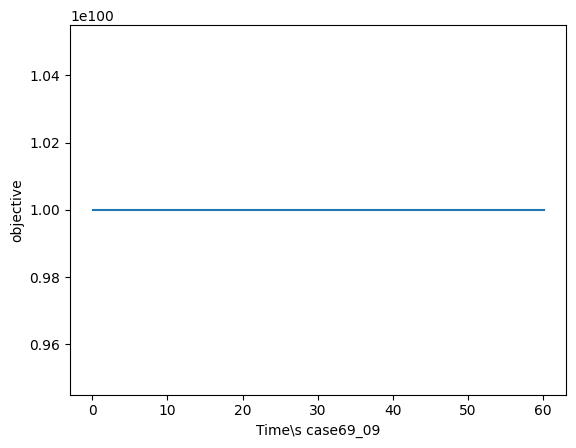

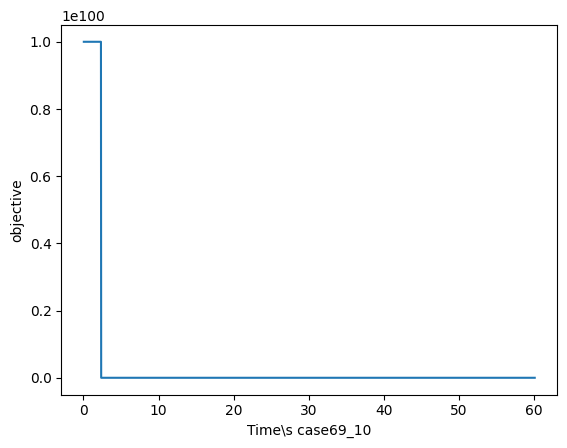

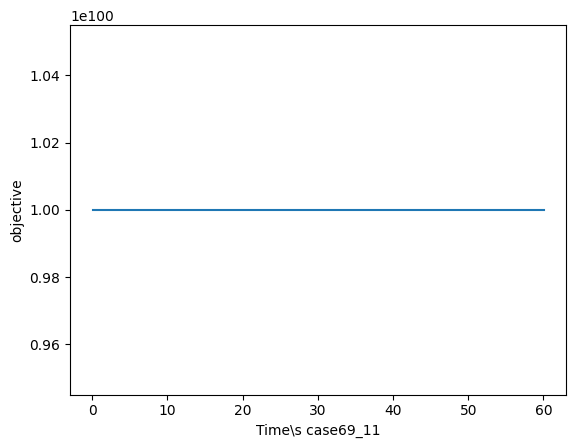

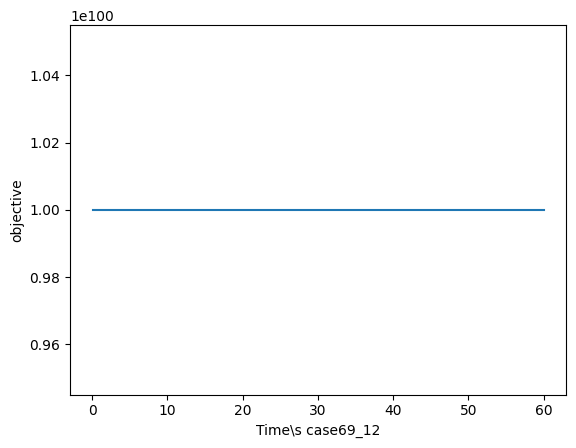

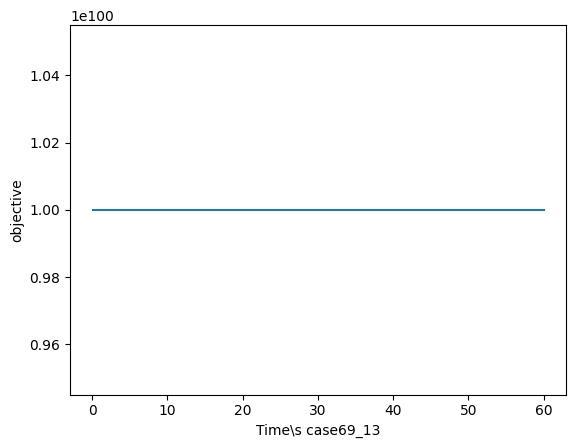

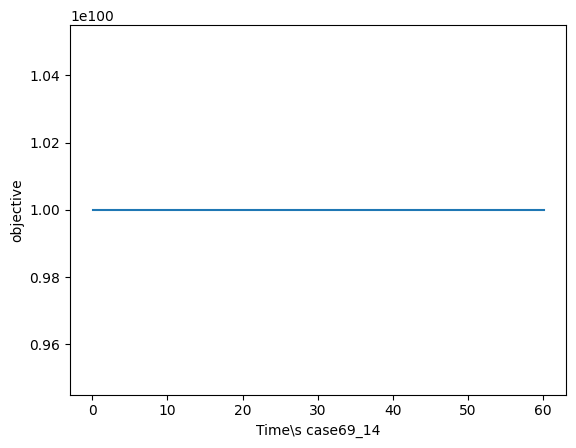

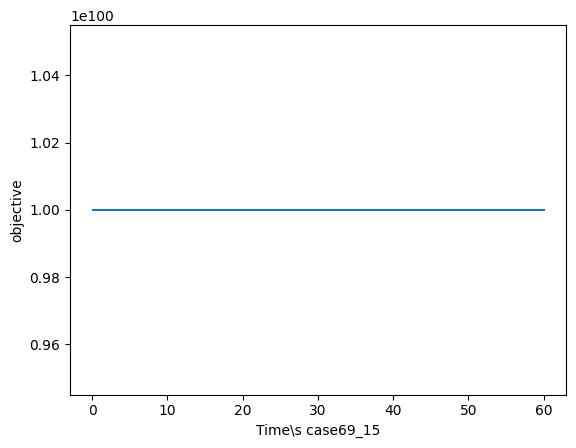

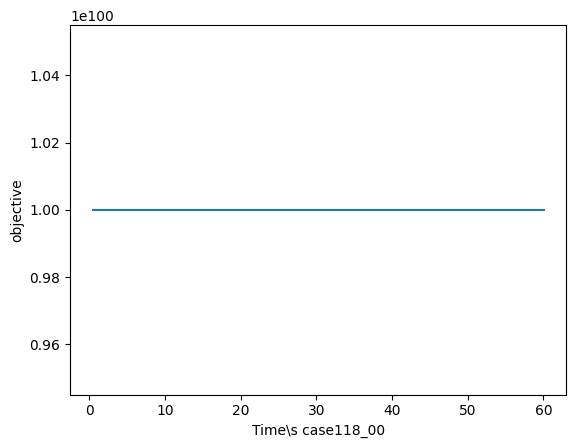

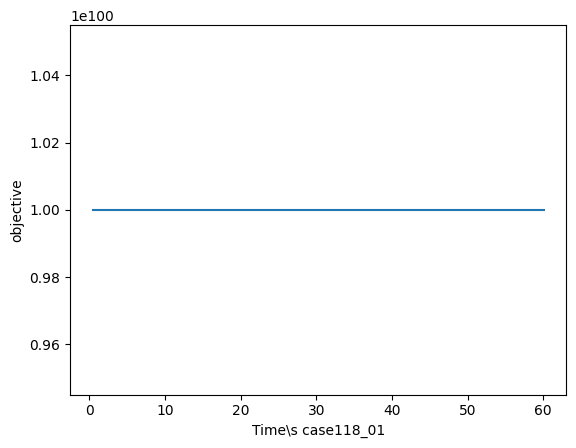

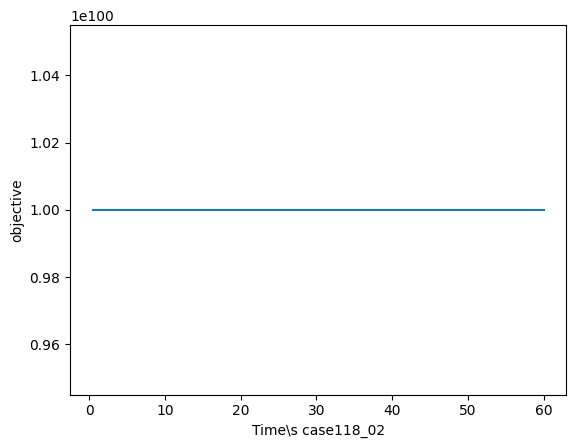

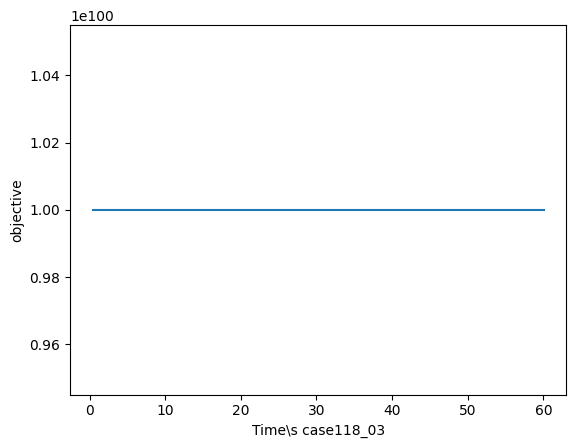

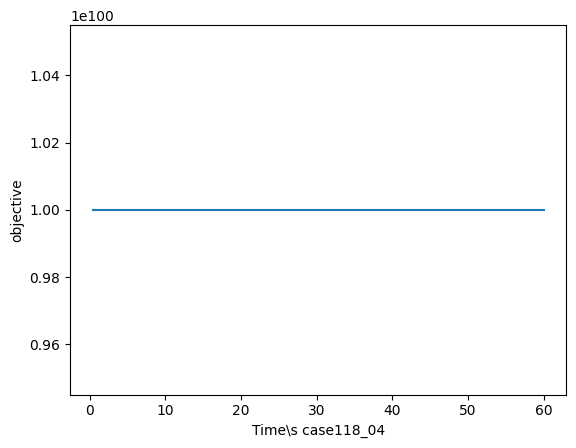

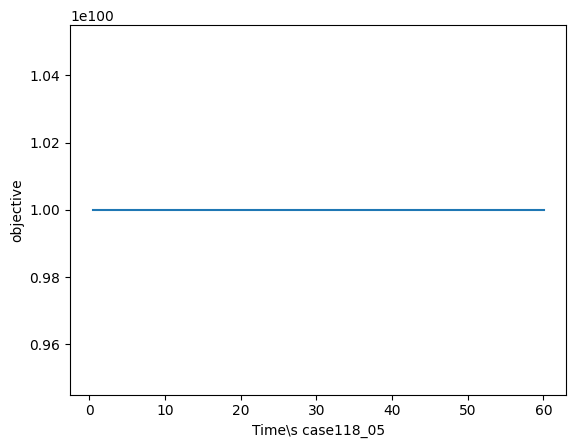

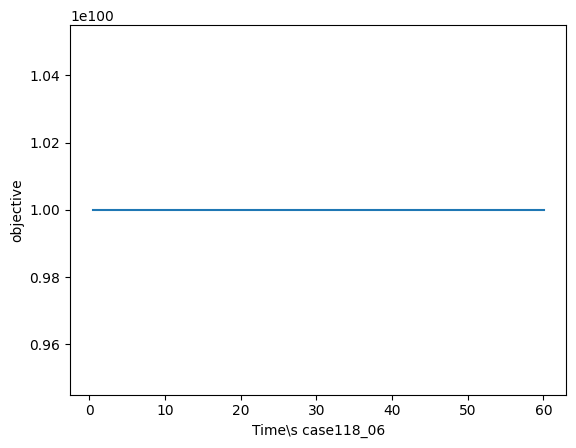

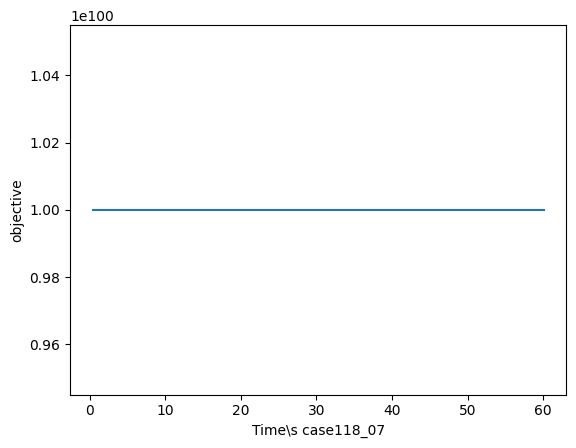

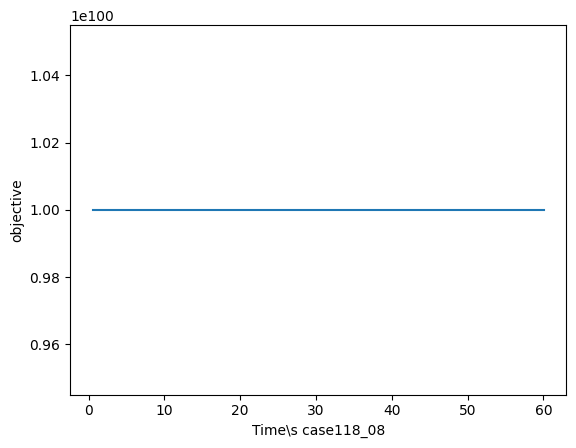

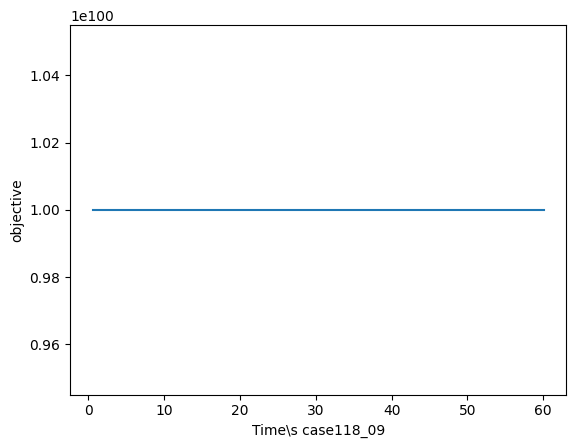

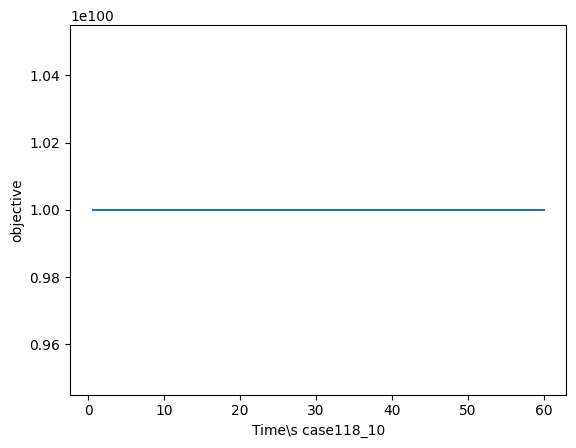

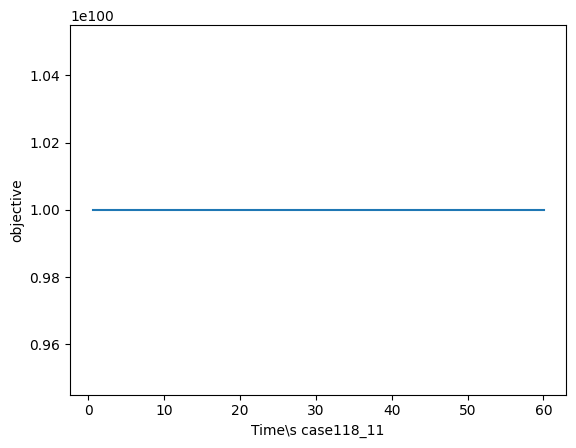

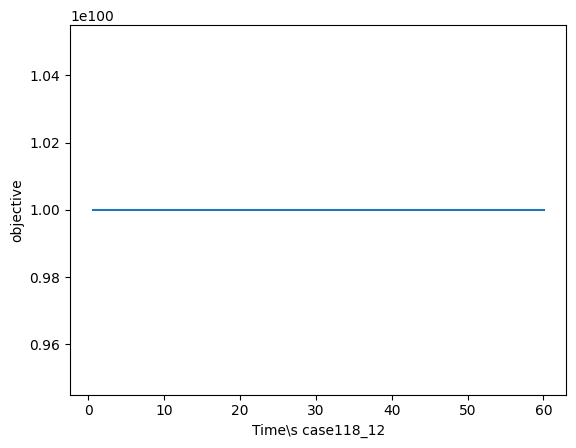

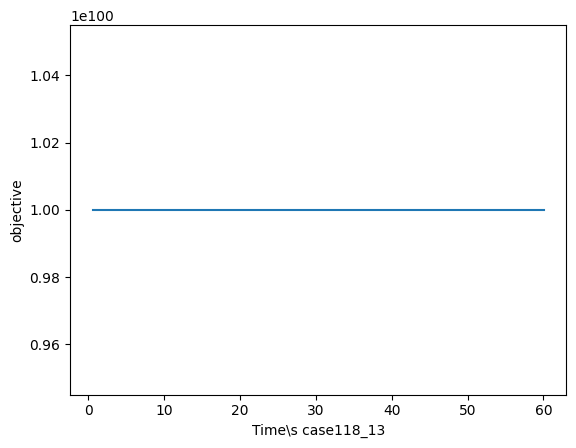

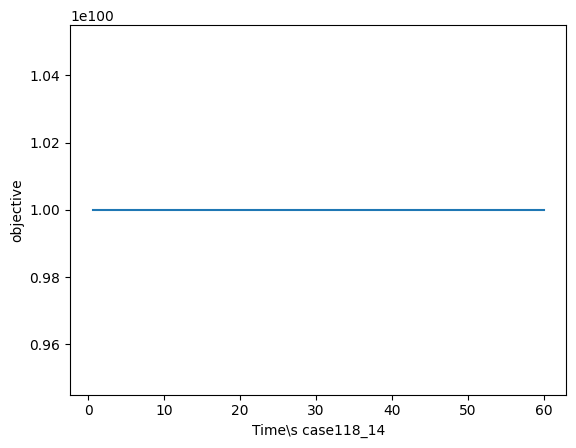

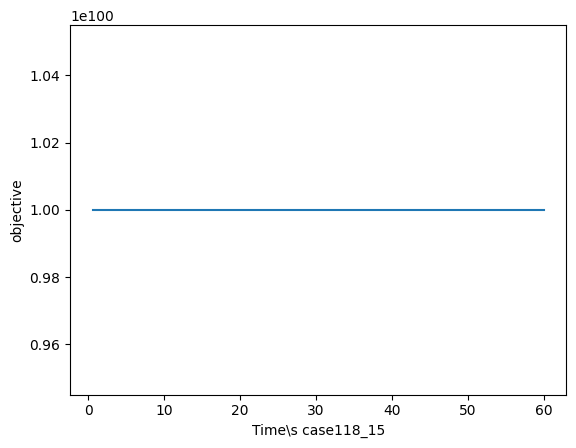

     Case  case33_10s  case33_30s  case33_60s     case69_10s     case69_30s   
0   10:00    0.110513    0.104224    0.104224  1.000000e+100  1.000000e+100  \
1   10:15    0.114410    0.114366    0.114366  1.000000e+100  1.000000e+100   
2   10:30    0.117733    0.110480    0.109259  1.000000e+100  1.000000e+100   
3   10:45    0.127866    0.106782    0.106782  1.000000e+100  1.000000e+100   
4   11:00    0.112225    0.112225    0.103299  1.000000e+100  1.000000e+100   
5   11:15    0.118354    0.118354    0.106195  1.000000e+100  1.000000e+100   
6   11:30    0.120093    0.100019    0.093520  1.000000e+100  1.000000e+100   
7   11:45    0.119595    0.107093    0.098547   2.010504e-01   2.010504e-01   
8   12:00    0.117421    0.108934    0.108041  1.000000e+100   1.320631e-01   
9   12:15    0.118792    0.118792    0.106019  1.000000e+100  1.000000e+100   
10  12:30    0.118021    0.118021    0.113955   1.748674e-01   1.748674e-01   
11  12:45    0.134098    0.112840    0.109296  1.000

In [3]:
'''
results processing
'''

from case33 import case33
from case69 import case69
from case118 import case118
import matplotlib.pyplot as plt

repeat_optimation = True

case1 = case33()
case2 = case69()
case3 = case118()

result = {}
env = Env_dnr()
table = table_data(10,30,60)
if repeat_optimation:
    for case in [case1, case2, case3]:
        result0 = test(case, env)
        result.update(result0)
    pickle.dump(result, open('optimization_result.pkl', 'wb')) 
else:
    result = pickle.load(open('optimization_result.pkl', 'rb'))

stop =1
sorted_keys = sorted(result.keys(), key=lambda k: len(str(k.replace('case', '').replace('_', ''))) + int(k.replace('case', '').replace('_', '')))
for key in sorted_keys:
    value = result[key]
    x = list( value.keys() )
    y = list( value.values() )
    table.data_process(x,y,key)
    plt.plot(x, y)
    plt.xlabel('Time\s '+key)
    plt.ylabel('objective')
    plt.show()

table.plot_table()


